<a href="https://colab.research.google.com/github/ispromadhka/Customer-segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation Using Unsupervised Machine Learning

**Objective:** Segment mall customers into distinct groups based on demographic and behavioral attributes to enable targeted marketing strategies.


**Methods:**
- K-Means Clustering (Elbow Method, Silhouette Analysis)
- DBSCAN Clustering
- Hierarchical Clustering (Agglomerative)
- Dimensionality Reduction: PCA, t-SNE

---

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 11, 'axes.titleweight': 'bold'})

COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#95C623']
sns.set_palette(COLORS)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

## 2. Data Loading

In [2]:
import kagglehub

path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")
df = pd.read_csv(path + '/Mall_Customers.csv')

df.shape

Using Colab cache for faster access to the 'customer-segmentation-tutorial-in-python' dataset.


(200, 5)

In [3]:
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


## 3. Data Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [6]:
df.describe().round(2)

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00,200.00
mean,100.50,38.85,60.56,50.20
std,57.88,13.97,26.26,25.82
min,1.00,18.00,15.00,1.00
25%,50.75,28.75,41.50,34.75
50%,100.50,36.00,61.50,50.00
75%,150.25,49.00,78.00,73.00
max,200.00,70.00,137.00,99.00


## 4. Exploratory Data Analysis

### 4.1 Gender Distribution

In [7]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'pie'}, {'type': 'bar'}]],
                    subplot_titles=('Customer Distribution by Gender', 'Average Metrics by Gender'))

gender_counts = df['Gender'].value_counts()
fig.add_trace(
    go.Pie(labels=gender_counts.index, values=gender_counts.values,
           marker_colors=['#A23B72', '#2E86AB'], hole=0.3,
           textinfo='percent+label', textfont_size=14),
    row=1, col=1
)

gender_stats = df.groupby('Gender')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()
fig.add_trace(
    go.Bar(name='Annual Income (k$)', x=gender_stats.index, y=gender_stats['Annual Income (k$)'],
           marker_color='#2E86AB', text=gender_stats['Annual Income (k$)'].round(1), textposition='outside'),
    row=1, col=2
)
fig.add_trace(
    go.Bar(name='Spending Score', x=gender_stats.index, y=gender_stats['Spending Score (1-100)'],
           marker_color='#A23B72', text=gender_stats['Spending Score (1-100)'].round(1), textposition='outside'),
    row=1, col=2
)

fig.update_layout(height=450, showlegend=True, template='plotly_white',
                  title_text='Gender Analysis', title_x=0.5, title_font_size=18)
fig.show()

### 4.2 Feature Distributions

In [8]:
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Age Distribution', 'Income Distribution', 'Spending Score Distribution'))

features_plot = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
colors_plot = ['#2E86AB', '#A23B72', '#F18F01']

for idx, (feature, color) in enumerate(zip(features_plot, colors_plot), 1):
    fig.add_trace(
        go.Histogram(x=df[feature], nbinsx=20, marker_color=color, opacity=0.8, name=feature),
        row=1, col=idx
    )
    fig.add_vline(x=df[feature].mean(), line_dash="dash", line_color="red",
                  annotation_text=f"Mean: {df[feature].mean():.1f}", row=1, col=idx)

fig.update_layout(height=400, showlegend=False, template='plotly_white',
                  title_text='Feature Distributions', title_x=0.5, title_font_size=18)
fig.show()

### 4.3 Correlation Analysis

In [9]:
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
correlation_matrix = df[numerical_cols].corr()

fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values, x=correlation_matrix.columns, y=correlation_matrix.columns,
    colorscale='RdBu_r', zmid=0, text=correlation_matrix.values.round(3),
    texttemplate='%{text}', textfont={'size': 14}, hoverongaps=False
))

fig.update_layout(title='Feature Correlation Matrix', title_x=0.5, title_font_size=18,
                  height=500, width=600, template='plotly_white')
fig.show()

### 4.4 Feature Relationships

In [10]:
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Income vs Spending', 'Age vs Spending', 'Age vs Income'))

scatter_config = [
    ('Annual Income (k$)', 'Spending Score (1-100)'),
    ('Age', 'Spending Score (1-100)'),
    ('Age', 'Annual Income (k$)')
]

for idx, (x_col, y_col) in enumerate(scatter_config, 1):
    for gender, color in zip(['Male', 'Female'], ['#2E86AB', '#A23B72']):
        mask = df['Gender'] == gender
        fig.add_trace(
            go.Scatter(x=df.loc[mask, x_col], y=df.loc[mask, y_col],
                       mode='markers', name=gender,
                       marker=dict(color=color, size=10, opacity=0.7),
                       showlegend=(idx == 1)),
            row=1, col=idx
        )
    fig.update_xaxes(title_text=x_col, row=1, col=idx)
    fig.update_yaxes(title_text=y_col, row=1, col=idx)

fig.update_layout(height=450, template='plotly_white',
                  title_text='Feature Relationships by Gender', title_x=0.5, title_font_size=18)
fig.show()

## 5. Data Preprocessing

In [11]:
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pd.DataFrame({
    'Feature': features,
    'Original Mean': X.mean().values,
    'Original Std': X.std().values,
    'Scaled Mean': X_scaled.mean(axis=0),
    'Scaled Std': X_scaled.std(axis=0)
}).round(4)

,Feature,Original Mean,Original Std,Scaled Mean,Scaled Std
0,Age,38.85,13.97,-0.0,1.0
1,Annual Income (k$),60.56,26.26,-0.0,1.0
2,Spending Score (1-100),50.20,25.82,-0.0,1.0


## 6. Optimal Number of Clusters

In [12]:
K_range = range(2, 11)
metrics = {'K': [], 'Inertia': [], 'Silhouette': [], 'Davies_Bouldin': [], 'Calinski_Harabasz': []}

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    metrics['K'].append(k)
    metrics['Inertia'].append(kmeans.inertia_)
    metrics['Silhouette'].append(silhouette_score(X_scaled, labels))
    metrics['Davies_Bouldin'].append(davies_bouldin_score(X_scaled, labels))
    metrics['Calinski_Harabasz'].append(calinski_harabasz_score(X_scaled, labels))

metrics_df = pd.DataFrame(metrics)
metrics_df.round(4)

,K,Inertia,Silhouette,Davies_Bouldin,Calinski_Harabasz
0,2,389.39,0.34,1.26,107.10
1,3,295.21,0.36,1.05,101.69
2,4,205.23,0.40,0.93,125.68
3,5,168.25,0.42,0.87,125.10
4,6,133.87,0.43,0.83,135.10
5,7,117.01,0.42,0.79,132.77
6,8,103.87,0.41,0.89,131.01
7,9,93.09,0.42,0.82,130.00
8,10,82.39,0.41,0.87,132.64


In [13]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=('Elbow Method', 'Silhouette Score (higher is better)',
                                    'Davies-Bouldin Index (lower is better)', 'Calinski-Harabasz Score (higher is better)'))

fig.add_trace(go.Scatter(x=metrics_df['K'], y=metrics_df['Inertia'],
                         mode='lines+markers', marker=dict(size=10), line=dict(width=2),
                         marker_color='#2E86AB', name='Inertia'), row=1, col=1)
fig.add_vline(x=6, line_dash="dash", line_color="red", row=1, col=1)

best_sil_k = metrics_df.loc[metrics_df['Silhouette'].idxmax(), 'K']
fig.add_trace(go.Scatter(x=metrics_df['K'], y=metrics_df['Silhouette'],
                         mode='lines+markers', marker=dict(size=10), line=dict(width=2),
                         marker_color='#A23B72', name='Silhouette'), row=1, col=2)
fig.add_vline(x=best_sil_k, line_dash="dash", line_color="red", row=1, col=2)

best_db_k = metrics_df.loc[metrics_df['Davies_Bouldin'].idxmin(), 'K']
fig.add_trace(go.Scatter(x=metrics_df['K'], y=metrics_df['Davies_Bouldin'],
                         mode='lines+markers', marker=dict(size=10), line=dict(width=2),
                         marker_color='#F18F01', name='Davies-Bouldin'), row=2, col=1)
fig.add_vline(x=best_db_k, line_dash="dash", line_color="red", row=2, col=1)

best_ch_k = metrics_df.loc[metrics_df['Calinski_Harabasz'].idxmax(), 'K']
fig.add_trace(go.Scatter(x=metrics_df['K'], y=metrics_df['Calinski_Harabasz'],
                         mode='lines+markers', marker=dict(size=10), line=dict(width=2),
                         marker_color='#95C623', name='Calinski-Harabasz'), row=2, col=2)
fig.add_vline(x=best_ch_k, line_dash="dash", line_color="red", row=2, col=2)

fig.update_xaxes(title_text='K', dtick=1)
fig.update_layout(height=700, showlegend=False, template='plotly_white',
                  title_text='Determining Optimal Number of Clusters', title_x=0.5, title_font_size=18)
fig.show()

In [14]:
pd.DataFrame({
    'Metric': ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
    'Optimal K': [int(best_sil_k), int(best_db_k), int(best_ch_k)],
    'Criterion': ['Maximum', 'Minimum', 'Maximum']
})

,Metric,Optimal K,Criterion
0,Silhouette Score,6,Maximum
1,Davies-Bouldin Index,7,Minimum
2,Calinski-Harabasz Score,6,Maximum


## 7. K-Means Clustering

In [15]:
OPTIMAL_K = 6

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
df['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

kmeans_metrics = {
    'Silhouette': silhouette_score(X_scaled, df['Cluster_KMeans']),
    'Davies_Bouldin': davies_bouldin_score(X_scaled, df['Cluster_KMeans']),
    'Calinski_Harabasz': calinski_harabasz_score(X_scaled, df['Cluster_KMeans'])
}

pd.DataFrame([kmeans_metrics], index=[f'K-Means (K={OPTIMAL_K})']).round(4)

,Silhouette,Davies_Bouldin,Calinski_Harabasz
K-Means (K=6),0.43,0.83,135.1


In [16]:
df['Cluster_KMeans'].value_counts().sort_index().to_frame('Count')

,Count
Cluster_KMeans,
0,45
1,39
2,33
3,39
4,23
5,21


### 7.1 Cluster Profiles

In [17]:
cluster_profiles = df.groupby('Cluster_KMeans').agg({
    'Age': ['mean', 'std'],
    'Annual Income (k$)': ['mean', 'std'],
    'Spending Score (1-100)': ['mean', 'std'],
    'CustomerID': 'count'
}).round(2)

cluster_profiles.columns = ['Age_Mean', 'Age_Std', 'Income_Mean', 'Income_Std',
                            'Spending_Mean', 'Spending_Std', 'Count']
cluster_profiles

,Age_Mean,Age_Std,Income_Mean,Income_Std,Spending_Mean,Spending_Std,Count
Cluster_KMeans,,,,,,,
0,56.33,8.45,54.27,8.98,49.07,6.30,45
1,26.79,7.06,57.10,10.16,48.13,9.97,39
2,41.94,10.18,88.94,16.59,16.97,9.96,33
3,32.69,3.73,86.54,16.31,82.13,9.36,39
4,25.00,5.30,25.26,7.72,77.61,13.27,23
5,45.52,11.77,26.29,7.44,19.38,12.56,21


In [18]:
def assign_segment(row):
    income, spending = row['Income_Mean'], row['Spending_Mean']
    if income > 70 and spending > 60:
        return 'VIP Customers'
    elif income > 70 and spending < 40:
        return 'High Potential'
    elif income < 45 and spending > 60:
        return 'At-Risk Spenders'
    elif income < 45 and spending < 40:
        return 'Low Engagement'
    else:
        return 'Average Customers'

cluster_profiles['Segment'] = cluster_profiles.apply(assign_segment, axis=1)
cluster_profiles[['Age_Mean', 'Income_Mean', 'Spending_Mean', 'Count', 'Segment']]

,Age_Mean,Income_Mean,Spending_Mean,Count,Segment
Cluster_KMeans,,,,,
0,56.33,54.27,49.07,45,Average Customers
1,26.79,57.10,48.13,39,Average Customers
2,41.94,88.94,16.97,33,High Potential
3,32.69,86.54,82.13,39,VIP Customers
4,25.00,25.26,77.61,23,At-Risk Spenders
5,45.52,26.29,19.38,21,Low Engagement


### 7.2 K-Means Visualization

In [19]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

fig = px.scatter(df, x='Annual Income (k$)', y='Spending Score (1-100)',
                 color='Cluster_KMeans', color_continuous_scale='viridis',
                 hover_data=['Age', 'Gender'],
                 title='K-Means Clustering: Income vs Spending Score')

fig.add_trace(go.Scatter(
    x=centers[:, 1], y=centers[:, 2], mode='markers',
    marker=dict(symbol='x', size=20, color='red', line=dict(width=2, color='black')),
    name='Centroids'
))

fig.update_layout(height=600, template='plotly_white', title_x=0.5, title_font_size=18)
fig.show()

## 8. DBSCAN Clustering

### 8.1 Epsilon Parameter Selection

In [20]:
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(distances))), y=distances,
                         mode='lines', line=dict(color='#2E86AB', width=2), name='K-Distance'))
fig.add_hline(y=0.55, line_dash="dash", line_color="red", annotation_text="Suggested eps = 0.55")

fig.update_layout(title='K-Distance Graph for DBSCAN Epsilon Selection', title_x=0.5, title_font_size=18,
                  xaxis_title='Data Points (sorted)', yaxis_title='6th Nearest Neighbor Distance',
                  height=450, template='plotly_white')
fig.show()

### 8.2 Parameter Tuning

In [21]:
eps_values = [0.5, 0.55, 0.6, 0.7, 0.8, 1.0]
dbscan_results = []

for eps in eps_values:
    labels = DBSCAN(eps=eps, min_samples=5).fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = (labels == -1).sum()
    dbscan_results.append({'eps': eps, 'clusters': n_clusters, 'noise': n_noise,
                           'noise_pct': round(n_noise/len(labels)*100, 1)})

pd.DataFrame(dbscan_results)

,eps,clusters,noise,noise_pct
0,0.50,6,60,30.0
1,0.55,4,39,19.5
2,0.60,2,28,14.0
3,0.70,1,14,7.0
4,0.80,1,6,3.0
5,1.00,1,2,1.0


### 8.3 DBSCAN Model

In [22]:
DBSCAN_EPS = 0.55
DBSCAN_MIN_SAMPLES = 5

dbscan = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES)
df['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(df['Cluster_DBSCAN'])) - (1 if -1 in df['Cluster_DBSCAN'].values else 0)
n_noise = (df['Cluster_DBSCAN'] == -1).sum()

mask = df['Cluster_DBSCAN'] != -1
dbscan_metrics = {}
if df.loc[mask, 'Cluster_DBSCAN'].nunique() > 1:
    dbscan_metrics = {
        'Silhouette': silhouette_score(X_scaled[mask], df.loc[mask, 'Cluster_DBSCAN']),
        'Davies_Bouldin': davies_bouldin_score(X_scaled[mask], df.loc[mask, 'Cluster_DBSCAN']),
        'Calinski_Harabasz': calinski_harabasz_score(X_scaled[mask], df.loc[mask, 'Cluster_DBSCAN'])
    }

pd.DataFrame({'Parameter': ['eps', 'min_samples', 'Clusters', 'Noise Points', 'Noise %'],
              'Value': [DBSCAN_EPS, DBSCAN_MIN_SAMPLES, n_clusters_dbscan, n_noise, f'{n_noise/len(df)*100:.1f}%']})

,Parameter,Value
0,eps,0.55
1,min_samples,5
2,Clusters,4
3,Noise Points,39
4,Noise %,19.5%


In [23]:
if dbscan_metrics:
    display(pd.DataFrame([dbscan_metrics], index=['DBSCAN (excl. noise)']).round(4))

,Silhouette,Davies_Bouldin,Calinski_Harabasz
DBSCAN (excl. noise),0.23,0.97,37.09


In [24]:
df['Cluster_DBSCAN'].value_counts().sort_index().to_frame('Count')

,Count
Cluster_DBSCAN,
-1,39
0,108
1,5
2,35
3,13


## 9. Hierarchical Clustering

### 9.1 Dendrogram

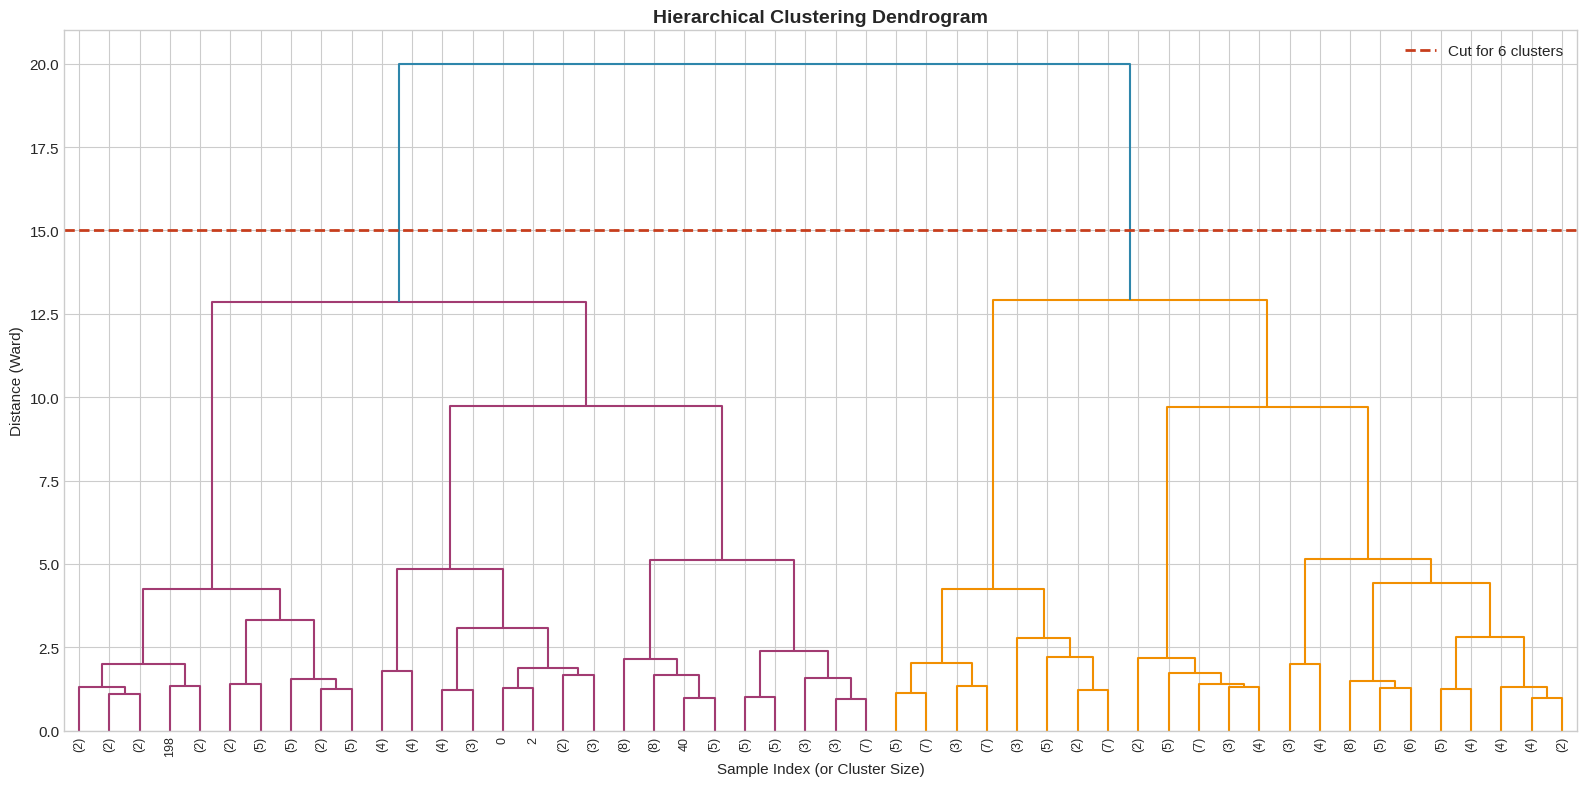

In [25]:
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=50, leaf_font_size=9, color_threshold=15)
plt.axhline(y=15, color='#C73E1D', linestyle='--', linewidth=2, label='Cut for 6 clusters')
plt.xlabel('Sample Index (or Cluster Size)')
plt.ylabel('Distance (Ward)')
plt.title('Hierarchical Clustering Dendrogram', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

### 9.2 Agglomerative Clustering

In [26]:
hierarchical = AgglomerativeClustering(n_clusters=6, linkage='ward')
df['Cluster_Hierarchical'] = hierarchical.fit_predict(X_scaled)

hier_metrics = {
    'Silhouette': silhouette_score(X_scaled, df['Cluster_Hierarchical']),
    'Davies_Bouldin': davies_bouldin_score(X_scaled, df['Cluster_Hierarchical']),
    'Calinski_Harabasz': calinski_harabasz_score(X_scaled, df['Cluster_Hierarchical'])
}

pd.DataFrame([hier_metrics], index=['Hierarchical (n=6, ward)']).round(4)

,Silhouette,Davies_Bouldin,Calinski_Harabasz
"Hierarchical (n=6, ward)",0.42,0.85,127.99


In [27]:
df['Cluster_Hierarchical'].value_counts().sort_index().to_frame('Count')

,Count
Cluster_Hierarchical,
0,45
1,45
2,39
3,28
4,22
5,21


## 10. Algorithm Comparison

In [28]:
comparison_df = pd.DataFrame({
    'Algorithm': ['K-Means', 'DBSCAN', 'Hierarchical'],
    'Clusters': [OPTIMAL_K, n_clusters_dbscan, 6],
    'Noise': [0, n_noise, 0],
    'Silhouette': [kmeans_metrics['Silhouette'], dbscan_metrics.get('Silhouette', np.nan), hier_metrics['Silhouette']],
    'Davies_Bouldin': [kmeans_metrics['Davies_Bouldin'], dbscan_metrics.get('Davies_Bouldin', np.nan), hier_metrics['Davies_Bouldin']],
    'Calinski_Harabasz': [kmeans_metrics['Calinski_Harabasz'], dbscan_metrics.get('Calinski_Harabasz', np.nan), hier_metrics['Calinski_Harabasz']]
})

comparison_df.round(4)

,Algorithm,Clusters,Noise,Silhouette,Davies_Bouldin,Calinski_Harabasz
0,K-Means,6,0,0.43,0.83,135.10
1,DBSCAN,4,39,0.23,0.97,37.09
2,Hierarchical,6,0,0.42,0.85,127.99


In [29]:
pd.DataFrame({
    'Metric': ['Silhouette (max)', 'Davies-Bouldin (min)', 'Calinski-Harabasz (max)'],
    'Best Algorithm': [
        comparison_df.loc[comparison_df['Silhouette'].idxmax(), 'Algorithm'],
        comparison_df.loc[comparison_df['Davies_Bouldin'].idxmin(), 'Algorithm'],
        comparison_df.loc[comparison_df['Calinski_Harabasz'].idxmax(), 'Algorithm']
    ]
})

,Metric,Best Algorithm
0,Silhouette (max),K-Means
1,Davies-Bouldin (min),K-Means
2,Calinski-Harabasz (max),K-Means


## 11. Dimensionality Reduction & Visualization

### 11.1 PCA

In [30]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'], df['PCA2'], df['PCA3'] = X_pca[:, 0], X_pca[:, 1], X_pca[:, 2]

pd.DataFrame({
    'Component': ['PC1', 'PC2', 'PC3', 'Total'],
    'Explained Variance': [f'{r:.2%}' for r in pca.explained_variance_ratio_] + [f'{sum(pca.explained_variance_ratio_):.2%}']
})

,Component,Explained Variance
0,PC1,44.27%
1,PC2,33.31%
2,PC3,22.43%
3,Total,100.00%


In [31]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('K-Means (PCA)', 'DBSCAN (PCA)', 'Hierarchical (PCA)'))

cluster_cols = ['Cluster_KMeans', 'Cluster_DBSCAN', 'Cluster_Hierarchical']

for idx, col in enumerate(cluster_cols, 1):
    fig.add_trace(
        go.Scatter(x=df['PCA1'], y=df['PCA2'], mode='markers',
                   marker=dict(size=10, color=df[col], colorscale='viridis', showscale=(idx == 3), opacity=0.7),
                   text=df[col], name=col.split('_')[1]),
        row=1, col=idx
    )
    fig.update_xaxes(title_text=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', row=1, col=idx)
    fig.update_yaxes(title_text=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', row=1, col=idx)

fig.update_layout(height=500, showlegend=False, template='plotly_white',
                  title_text='Cluster Visualization in PCA Space', title_x=0.5, title_font_size=18)
fig.show()

### 11.2 t-SNE

In [32]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

df['TSNE1'], df['TSNE2'] = X_tsne[:, 0], X_tsne[:, 1]

In [33]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('K-Means (t-SNE)', 'DBSCAN (t-SNE)', 'Hierarchical (t-SNE)'))

for idx, col in enumerate(cluster_cols, 1):
    fig.add_trace(
        go.Scatter(x=df['TSNE1'], y=df['TSNE2'], mode='markers',
                   marker=dict(size=10, color=df[col], colorscale='plasma', showscale=(idx == 3), opacity=0.7),
                   text=df[col], name=col.split('_')[1]),
        row=1, col=idx
    )
    fig.update_xaxes(title_text='t-SNE 1', row=1, col=idx)
    fig.update_yaxes(title_text='t-SNE 2', row=1, col=idx)

fig.update_layout(height=500, showlegend=False, template='plotly_white',
                  title_text='Cluster Visualization in t-SNE Space', title_x=0.5, title_font_size=18)
fig.show()

### 11.3 Interactive 3D Visualization

In [34]:
fig = px.scatter_3d(df, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)',
                    color='Cluster_KMeans', color_continuous_scale='viridis',
                    hover_data=['Gender', 'CustomerID'],
                    title='K-Means Clusters in 3D Feature Space')

fig.update_layout(height=700, template='plotly_white', title_x=0.5, title_font_size=18,
                  scene=dict(xaxis_title='Age', yaxis_title='Annual Income (k$)', zaxis_title='Spending Score'))
fig.show()

In [35]:
fig = px.scatter_3d(df, x='PCA1', y='PCA2', z='PCA3',
                    color='Cluster_KMeans', color_continuous_scale='viridis',
                    hover_data=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
                    title='K-Means Clusters in PCA 3D Space')

fig.update_layout(height=700, template='plotly_white', title_x=0.5, title_font_size=18,
                  scene=dict(xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]:.1%})',
                             yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]:.1%})',
                             zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]:.1%})'))
fig.show()

## 12. Final Cluster Visualization

In [36]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Income vs Spending Score', 'Age vs Spending Score'))

for cluster in sorted(df['Cluster_KMeans'].unique()):
    mask = df['Cluster_KMeans'] == cluster
    color = COLORS[cluster % len(COLORS)]

    fig.add_trace(
        go.Scatter(x=df.loc[mask, 'Annual Income (k$)'], y=df.loc[mask, 'Spending Score (1-100)'],
                   mode='markers', name=f'Cluster {cluster}',
                   marker=dict(size=12, color=color, opacity=0.7, line=dict(width=1, color='white'))),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=df.loc[mask, 'Age'], y=df.loc[mask, 'Spending Score (1-100)'],
                   mode='markers', name=f'Cluster {cluster}', showlegend=False,
                   marker=dict(size=12, color=color, opacity=0.7, line=dict(width=1, color='white'))),
        row=1, col=2
    )

centers = scaler.inverse_transform(kmeans.cluster_centers_)
fig.add_trace(go.Scatter(x=centers[:, 1], y=centers[:, 2], mode='markers', name='Centroids',
                         marker=dict(symbol='x', size=18, color='black', line=dict(width=2))), row=1, col=1)
fig.add_trace(go.Scatter(x=centers[:, 0], y=centers[:, 2], mode='markers', name='Centroids', showlegend=False,
                         marker=dict(symbol='x', size=18, color='black', line=dict(width=2))), row=1, col=2)

fig.update_xaxes(title_text='Annual Income (k$)', row=1, col=1)
fig.update_yaxes(title_text='Spending Score (1-100)', row=1, col=1)
fig.update_xaxes(title_text='Age', row=1, col=2)
fig.update_yaxes(title_text='Spending Score (1-100)', row=1, col=2)

fig.update_layout(height=550, template='plotly_white',
                  title_text='Final Customer Segments', title_x=0.5, title_font_size=18)
fig.show()

## 13. Summary

### Key Findings

**Best Algorithm:** K-Means (K=6) — highest Silhouette score, lowest Davies-Bouldin index, highest Calinski-Harabasz score.

### Customer Segments

| Segment | Characteristics | Recommended Strategy |
|---------|----------------|---------------------|
| VIP Customers | High income, high spending | Loyalty programs, exclusive offers, personalized service |
| High Potential | High income, low spending | Targeted marketing, engagement campaigns, premium recommendations |
| At-Risk Spenders | Low income, high spending | Installment plans, budget options, retention programs |
| Low Engagement | Low income, low spending | Basic promotions, cost-effective campaigns |
| Average Customers | Moderate values | Standard marketing, seasonal promotions |

In [37]:
pd.DataFrame({
    'Metric': ['Dataset Size', 'Features Used', 'Best Algorithm', 'Optimal Clusters',
               'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
    'Value': [len(df), len(features), 'K-Means', OPTIMAL_K,
              round(kmeans_metrics['Silhouette'], 4),
              round(kmeans_metrics['Davies_Bouldin'], 4),
              round(kmeans_metrics['Calinski_Harabasz'], 2)]
})

,Metric,Value
0,Dataset Size,200
1,Features Used,3
2,Best Algorithm,K-Means
3,Optimal Clusters,6
4,Silhouette Score,0.43
5,Davies-Bouldin Index,0.83
6,Calinski-Harabasz Score,135.1


In [38]:
export_cols = ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
               'Spending Score (1-100)', 'Cluster_KMeans', 'Cluster_DBSCAN', 'Cluster_Hierarchical']
df[export_cols].to_csv('customer_segments.csv', index=False)